## 2-Triangle mesh with Greedy II algorithm

- We have proven (see greedyproof.pdf) that the Greedy II algorithm pitches tents to any time value for a mesh of 1 simplex of any dimension.
- Numerous simulations on different realistic (e.g. more than 100 elements) meshes in 2D and 3D have been performed.  We have thus far never seen either the Greedy or Greedy II algorithm (see algorithm.pdf) get stuck when a constant wavespeed is used.
- We show here examples where Greedy II fails for a mesh with 2 triangles with constant wavespeed.

In [302]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


In [303]:
class simplex(object):
    """
    A simplex
    """

    def __init__(self, pts, cbar=1.0):
        """
        INPUTS

        pts: d+1 x d numpy array, each row a vertex of a conforming simplex
        cbar: float wavespeed
        """
        self.pts = pts                # vertex points of simplex
        self.d = pts.shape[1]         # simplex dimension
        self.cbar = cbar              # wave speed
        self.nmls = None              # cached normal vectors
        self.ts = np.zeros(self.d+1)  # current vertex times
        
        # lists of pre-computed matrices, vectors and constants, one list element per vertex
        # see greedyproof.pdf for details
        Ms, Msums, Mdot1s = [], [], []  
        for i in range(self.d+1):
            At = np.roll(pts - pts[i, :], -(i+1), 0)[:self.d, :]
            M = la.inv(At@At.T)
            Ms.append(M)
            Mdot1s.append(M.sum(axis=0))
            Msums.append(M.sum())
        self.Ms, self.Msums, self.Mdot1s = Ms, Msums, Mdot1s


    def gradnormsq(self):
        """
        Compute ||∇ τ||²
        """
        dts = self.dts(0)
        return dts.dot(self.Ms[0]).dot(dts)

    def dts(self, ix):
        """
        Compute dtₖ, the vector of time differences relative to vₖ

        INPUTS

        ix: index of reference vertex
        """
        return np.roll(self.ts - self.ts[ix], -(ix+1))[:self.d]

    def kbar(self, ix):
        """
        Compute time increment kbar for vertex ix

        INPUTS

        ts: numpy array with d+1 elements representing vertex times
        """
        M, Msum, Mdot1 = self.Ms[ix], self.Msums[ix], self.Mdot1s[ix]
        c = self.cbar
        dt = self.dts(ix)
        m1dt = Mdot1.dot(dt)
        disc = m1dt**2 - Msum * (dt.dot(M).dot(dt) - 1/c)
        if disc < 0:
            disc = 0.
        return (m1dt + np.sqrt(disc))/Msum


In [304]:
class slab2d(object):
    """
    A tent slab based on a 2D simplicial mesh with 2 triangles
    """

    def __init__(self, cbar=1.0, vpts=None):
        """
        INPUTS
        cbar: float wavespeed, default 1.0
        vpts: 4x2 numpy array representing 4 2D points (if not set
              (if not specified, random vertices are generated)
        """
        self.cbar = cbar
        
        if vpts is None:
            # generate random vertices for the two triangles
            pts1 = np.random.rand(3, 2)
            diffs1 = (pts1 - pts1[0, :])[1:, :]
            if la.det(diffs1) <= 0:
                pts1[[0, 1], :] = pts1[[1, 0], :]

            pts2i = pts1[[0, 2], :]
            pts2 = np.vstack((pts2i, np.random.rand(2)))
            diffs2 = (pts2 - pts2[0, :])[1:, :]
            while la.det(diffs2) <= 0:
                pts2 = np.vstack((pts2i, np.random.rand(2)))
                diffs2 = (pts2 - pts2[0, :])[1:, :]
            self.vpts = np.vstack((pts1, pts2[-1, :]))
        else:
            # use the provided vertices
            self.vpts = vpts
            pts1 = self.vpts[:-1, :]
            pts2 = self.vpts[[0, 2, 3], :]

        # element to vertex and vertex to element maps
        self.v2e = {0: [0, 1], 1: [0], 2: [0, 1], 3: [1]}
        self.e2v = {0: [0, 1, 2], 1: [0, 2, 3]}

        self.els = [simplex(pts1, cbar), simplex(pts2, cbar)]
        self.ts = np.zeros(4)
        self.minstep = 1.0e16

    def elix(self, e, v):
        """
        Return the index of v in the context of element e
        """
        vs = self.e2v[e]
        if v not in vs:
            raise ValueError()
        return vs.index(v)

    def updatets(self, v):
        """
        Update the time for the specified vertex based on global times
        """
        for e in self.v2e[v]:
            ix = self.elix(e, v)
            self.els[e].ts[ix] = self.ts[v]

    def kbars(self, v):
        """
        Given a vertex, compute time increments which would set ||∇ τ|| = 1/cbar
        for each adjacent element.
        """
        result = []
        for e in self.v2e[v]:
            el = self.els[e]
            eix = self.elix(e, v)
            result.append(el.kbar(eix))
        return result
    
    def ktildes(self):
        """
        Compute the time increment for each vertex v such that
        max over elements incident on v of ||∇ τ|| = 1/cbar
        """
        result = []
        for v in range(4):
            kbars = self.kbars(v)
            result.append(min(kbars))
        return result

    def step(self, verbose=False, vtx=None):
        """
        If vtx is not given, select the vertex with maximal ktilde
        and pitch a tent at that vertex.
        If vtx is specified, override to pitch a tent at vtx
        """
        ktildes = self.ktildes()
        imax = np.argmax(ktildes)  # global index of vertex w/ max ktilde
        ktmax = max(0, ktildes[imax])
        if ktmax < self.minstep:
            self.minstep = ktmax
        if vtx is not None:
            imax = vtx
        self.ts[imax] += max(0, ktildes[imax])
        self.updatets(imax)
        if verbose:
            print("ktildes", ktildes)
            print("updated vertex", imax)
            print("new times", self.ts)
            print("minstep", self.minstep)
            
        # preview ktildes for next step, but don't use them to pitch a tent
        ktildes = self.ktildes()
        print("next step ktildes", ktildes)

        return ktmax

    def plot(self):
        """
        Draw the 2 triangle mesh
        """
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        for el in self.els:
            lpts = np.vstack((el.pts, el.pts[0, :])).tolist()
            ppts = list(zip(*lpts))
            ax.plot(ppts[0], ppts[1], 'g-')
        vpts = self.vpts.tolist()
        ppts = list(zip(*vpts))
        ax.scatter(ppts[0], ppts[1], c='blue')
        for i, pt in enumerate(vpts):
            plt.annotate("  v{}".format(i), pt)
        plt.show()


## Example 1:  $v_0 v_2 v_1$ a right angle, $v_0, v_1, v_3$ colinear 

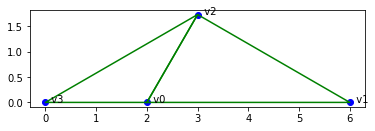

In [305]:
vpts = np.array([[2, 0], [6.0, 0], [3, np.sqrt(3)], [0, 0]])

s = slab2d(vpts=vpts)
s.plot()

In [306]:
s.step(True)


ktildes [1.0, 3.4641016151377553, 1.7320508075688767, 1.7320508075688772]
updated vertex 1
new times [0.         3.46410162 0.         0.        ]
minstep 3.4641016151377553
next step ktildes [0.0, 0.0, 1.7320508075688767, 1.7320508075688772]


3.4641016151377553

In [307]:
s.step(True)

ktildes [0.0, 0.0, 1.7320508075688767, 1.7320508075688772]
updated vertex 3
new times [0.         3.46410162 0.         1.73205081]
minstep 1.7320508075688772
next step ktildes [0.0, 0.0, -3.330669073875468e-16, 3.3306690738754696e-16]


1.7320508075688772

In [308]:
s.step(True)

ktildes [0.0, 0.0, -3.330669073875468e-16, 3.3306690738754696e-16]
updated vertex 3
new times [0.         3.46410162 0.         1.73205081]
minstep 3.3306690738754696e-16
next step ktildes [0.0, 0.0, -1.4988010832439607e-15, -3.3306690738754696e-16]


3.3306690738754696e-16

In [309]:
s.step(True)

ktildes [0.0, 0.0, -1.4988010832439607e-15, -3.3306690738754696e-16]
updated vertex 0
new times [0.         3.46410162 0.         1.73205081]
minstep 0
next step ktildes [0.0, 0.0, -1.4988010832439607e-15, -3.3306690738754696e-16]


0

## Tent slab is stuck
Once we get zero for the max ktilde, we're done.  The slab cannot complete

## Example 2 $v_0 v_2 v_1$ a right angle, $v_1, v_3$ distant from edge $v_0 v_1$

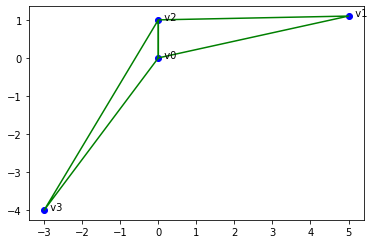

In [310]:
vpts = np.array([[0, 0], [5, 1.1], [0, 1.], [-3., -4.]])
s = slab2d(vpts=vpts)
s.plot()

In [311]:
s.step(True)

ktildes [0.5144957554275265, 5.0000000000000115, 0.6, 3.0000000000000053]
updated vertex 1
new times [0. 5. 0. 0.]
minstep 5.0000000000000115
next step ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, 0.41968714231208504, 3.0000000000000053]


5.0000000000000115

In [312]:
s.step(True)

ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, 0.41968714231208504, 3.0000000000000053]
updated vertex 3
new times [0. 5. 0. 3.]
minstep 3.0000000000000053
next step ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, -1.3589129821411912e-15, -4.9960036108132226e-15]


3.0000000000000053

In [313]:
s.step(True)

ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, -1.3589129821411912e-15, -4.9960036108132226e-15]
updated vertex 2
new times [0. 5. 0. 3.]
minstep 0
next step ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, -1.3589129821411912e-15, -4.9960036108132226e-15]


0

## Maybe a slight modification could help
The vertices with two elements are at a disadvantage.  If one of their ktilde values is only slightly less than that of a single-element vertex, maybe we could override the algorithm to keep things going.

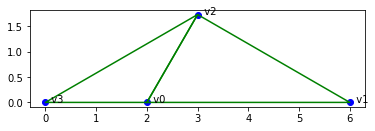

In [314]:
vpts = np.array([[2, 0], [6.0, 0], [3, np.sqrt(3)], [0, 0]])

s = slab2d(vpts=vpts)
s.plot()

In [315]:
s.step(True)

ktildes [1.0, 3.4641016151377553, 1.7320508075688767, 1.7320508075688772]
updated vertex 1
new times [0.         3.46410162 0.         0.        ]
minstep 3.4641016151377553
next step ktildes [0.0, 0.0, 1.7320508075688767, 1.7320508075688772]


3.4641016151377553

We see that vertices 2 and 3 are nearly tied, but that vertex 3 is slightly larger.  Let's override to pitch the tent at vertex 2

In [316]:
s.step(True, 2)

ktildes [0.0, 0.0, 1.7320508075688767, 1.7320508075688772]
updated vertex 2
new times [0.         3.46410162 1.73205081 0.        ]
minstep 1.7320508075688772
next step ktildes [1.7320508075688774, 6.661338147750941e-16, 0.0, 1.3322676295501878e-15]


1.7320508075688772

In [317]:
s.step(True)

ktildes [1.7320508075688774, 6.661338147750941e-16, 0.0, 1.3322676295501878e-15]
updated vertex 0
new times [1.73205081 3.46410162 1.73205081 0.        ]
minstep 1.7320508075688772
next step ktildes [-2.220446049250313e-16, 1.7320508075688765, 1.7320508075688767, 3.4641016151377557]


1.7320508075688774

In [318]:
s.step(True)

ktildes [-2.220446049250313e-16, 1.7320508075688765, 1.7320508075688767, 3.4641016151377557]
updated vertex 3
new times [1.73205081 3.46410162 1.73205081 3.46410162]
minstep 1.7320508075688772
next step ktildes [1.732050807568876, 1.7320508075688765, -1.998401444325281e-15, -6.661338147750939e-16]


3.4641016151377557

This time vertices 0 and 1 are nearly tied.  Lets override to pitch the tent at vertex 0

In [319]:
s.step(True,0)

ktildes [1.732050807568876, 1.7320508075688765, -1.998401444325281e-15, -6.661338147750939e-16]
updated vertex 0
new times [3.46410162 3.46410162 1.73205081 3.46410162]
minstep 1.7320508075688765
next step ktildes [2.220446049250313e-16, 3.3306690738754706e-16, 3.464101615137752, 1.7320508075688759]


1.7320508075688765

In [320]:
s.step(True)

ktildes [2.220446049250313e-16, 3.3306690738754706e-16, 3.464101615137752, 1.7320508075688759]
updated vertex 2
new times [3.46410162 3.46410162 5.19615242 3.46410162]
minstep 1.7320508075688765
next step ktildes [1.7320508075688783, 3.464101615137758, 9.992007221626405e-16, 2.6645352591003757e-15]


3.464101615137752

In [321]:
s.step(True)

ktildes [1.7320508075688783, 3.464101615137758, 9.992007221626405e-16, 2.6645352591003757e-15]
updated vertex 1
new times [3.46410162 6.92820323 5.19615242 3.46410162]
minstep 1.7320508075688765
next step ktildes [1.7320508075688783, 0.0, -8.326672684688673e-16, 2.6645352591003757e-15]


3.464101615137758

In [322]:
s.step(True)

ktildes [1.7320508075688783, 0.0, -8.326672684688673e-16, 2.6645352591003757e-15]
updated vertex 0
new times [5.19615242 6.92820323 5.19615242 3.46410162]
minstep 1.7320508075688765
next step ktildes [-5.551115123125783e-16, 1.7320508075688703, 1.7320508075688812, 3.4641016151377553]


1.7320508075688783

In [323]:
s.step(True)

ktildes [-5.551115123125783e-16, 1.7320508075688703, 1.7320508075688812, 3.4641016151377553]
updated vertex 3
new times [5.19615242 6.92820323 5.19615242 6.92820323]
minstep 1.7320508075688765
next step ktildes [1.7320508075688712, 1.7320508075688703, 3.330669073875468e-16, 6.661338147750939e-16]


3.4641016151377553

In [324]:
s.step(True)

ktildes [1.7320508075688712, 1.7320508075688703, 3.330669073875468e-16, 6.661338147750939e-16]
updated vertex 0
new times [6.92820323 6.92820323 5.19615242 6.92820323]
minstep 1.7320508075688712
next step ktildes [-2.220446049250313e-16, 0.0, 3.4641016151377477, 1.7320508075688725]


1.7320508075688712

In [325]:
s.step(True)

ktildes [-2.220446049250313e-16, 0.0, 3.4641016151377477, 1.7320508075688725]
updated vertex 2
new times [6.92820323 6.92820323 8.66025404 6.92820323]
minstep 1.7320508075688712
next step ktildes [1.732050807568881, 3.464101615137754, 3.330669073875468e-16, 1.3322676295501878e-15]


3.4641016151377477

## Overriding seems to solve the issue in this case
Let's see if we can do the same for the other example

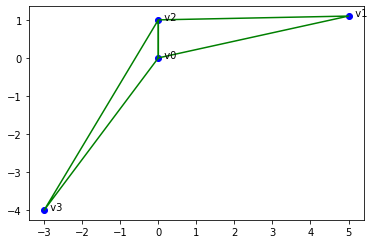

In [326]:
vpts = np.array([[0, 0], [5, 1.1], [0, 1.], [-3., -4.]])
s = slab2d(vpts=vpts)
s.plot()

In [327]:
s.step(True)

ktildes [0.5144957554275265, 5.0000000000000115, 0.6, 3.0000000000000053]
updated vertex 1
new times [0. 5. 0. 0.]
minstep 5.0000000000000115
next step ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, 0.41968714231208504, 3.0000000000000053]


5.0000000000000115

If we choose the max ktilde of 3.0 in the next step, we will have painted ourselves into the corner.  Let's force it to vertex 2 instead

In [328]:
s.step(True, 2)

ktildes [-1.1102299607446127e-13, -7.632783294297988e-15, 0.41968714231208504, 3.0000000000000053]
updated vertex 2
new times [0.         5.         0.41968714 0.        ]
minstep 3.0000000000000053
next step ktildes [0.8027464329033552, 6.245004513516535e-15, 5.030102410310467e-16, 1.0442579168256885]


3.0000000000000053

In [329]:
s.step(True)

ktildes [0.8027464329033552, 6.245004513516535e-15, 5.030102410310467e-16, 1.0442579168256885]
updated vertex 3
new times [0.         5.         0.41968714 1.04425792]
minstep 1.0442579168256885
next step ktildes [0.8027464329033552, 6.245004513516535e-15, 3.996802888650562e-16, 0.0]


1.0442579168256885

In [330]:
s.step(True)

ktildes [0.8027464329033552, 6.245004513516535e-15, 3.996802888650562e-16, 0.0]
updated vertex 0
new times [0.80274643 5.         0.41968714 1.04425792]
minstep 0.8027464329033552
next step ktildes [-2.7744477824499117e-16, 1.3183898417423795e-14, 0.9437171108685248, 4.061896950490996]


0.8027464329033552

If we greedily choose the max ktilde here, the max ktilde for the next step will be near machine epsilon, so again let's pitch the tent at v2 instead.

In [331]:
s.step(True, 2)

ktildes [-2.7744477824499117e-16, 1.3183898417423795e-14, 0.9437171108685248, 4.061896950490996]
updated vertex 2
new times [0.80274643 5.         1.36340425 1.04425792]
minstep 0.8027464329033552
next step ktildes [1.0274490710383561, 0.5597079769272594, 2.3980817331903373e-16, -9.992007221626444e-16]


4.061896950490996

In [332]:
s.step(True)

ktildes [1.0274490710383561, 0.5597079769272594, 2.3980817331903373e-16, -9.992007221626444e-16]
updated vertex 0
new times [1.8301955  5.         1.36340425 1.04425792]
minstep 0.8027464329033552
next step ktildes [1.763295392051719e-16, 0.7385627783718831, 1.18508252939933, 5.306205180320877]


1.0274490710383561

In [333]:
s.step(True)

ktildes [1.763295392051719e-16, 0.7385627783718831, 1.18508252939933, 5.306205180320877]
updated vertex 3
new times [1.8301955  5.         1.36340425 6.3504631 ]
minstep 0.8027464329033552
next step ktildes [0.20498440379274052, 0.7385627783718831, -7.793765632868596e-15, -1.79856129989276e-14]


5.306205180320877

In [334]:
s.step(True)

ktildes [0.20498440379274052, 0.7385627783718831, -7.793765632868596e-15, -1.79856129989276e-14]
updated vertex 1
new times [1.8301955  5.73856278 1.36340425 6.3504631 ]
minstep 0.7385627783718831
next step ktildes [-4.605583318866853e-15, 7.632783294297988e-15, -7.793765632868596e-15, -1.79856129989276e-14]


0.7385627783718831

In this example, It was not so obvious when we needed to override the greedy algorithm.  One thought is to allow "unpitching" a tent.  If we reach a point in the algorithm where all ktilde values are zero, perhaps we could backtrack and try overriding to overcome the issue.

## Other examples
Most of the examples encountered so far have been similar to Example 1 or Example 2, but the tests have not been exhaustive.  Here is one other example, which requires about 20 steps to get stuck.

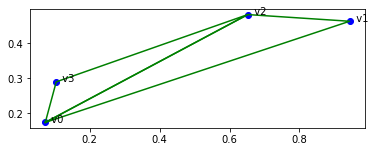

In [362]:
vpts = np.array([[0.07305531, 0.17414394],
                 [0.94356742, 0.46345767],
                 [0.65216235, 0.48257233],
                 [0.10436469, 0.29013826]])
s = slab2d(vpts=vpts)
s.plot()

In [363]:
s.step(True)

ktildes [0.0990613047264648, 0.15385459955685474, 0.11004443808990222, 0.08766148513701202]
updated vertex 1
new times [0.        0.1538546 0.        0.       ]
minstep 0.15385459955685474
next step ktildes [-3.1838290537703205e-16, 0.0, 0.21697124259945214, 0.08766148513701202]


0.15385459955685474

In [364]:
s.step(True)

ktildes [-3.1838290537703205e-16, 0.0, 0.21697124259945214, 0.08766148513701202]
updated vertex 2
new times [0.         0.1538546  0.21697124 0.        ]
minstep 0.15385459955685474
next step ktildes [0.06647948803151638, 0.2903974663267717, 0.0, 0.10989933247505705]


0.21697124259945214

In [365]:
s.step(True)

ktildes [0.06647948803151638, 0.2903974663267717, 0.0, 0.10989933247505705]
updated vertex 1
new times [0.         0.44425207 0.21697124 0.        ]
minstep 0.15385459955685474
next step ktildes [-2.918509965956127e-16, 0.0, 0.19255761970387186, 0.10989933247505705]


0.2903974663267717

In [366]:
s.step(True)

ktildes [-2.918509965956127e-16, 0.0, 0.19255761970387186, 0.10989933247505705]
updated vertex 2
new times [0.         0.44425207 0.40952886 0.        ]
minstep 0.15385459955685474
next step ktildes [0.02227020325051603, 0.24041018562945077, 4.3022575207353684e-17, 0.11977129746216232]


0.19255761970387186

In [367]:
s.step(True)

ktildes [0.02227020325051603, 0.24041018562945077, 4.3022575207353684e-17, 0.11977129746216232]
updated vertex 1
new times [0.         0.68466225 0.40952886 0.        ]
minstep 0.15385459955685474
next step ktildes [9.153508529589672e-16, -2.1024282585813245e-17, 0.06919392825420088, 0.11977129746216232]


0.24041018562945077

In [368]:
s.step(True)

ktildes [9.153508529589672e-16, -2.1024282585813245e-17, 0.06919392825420088, 0.11977129746216232]
updated vertex 3
new times [0.         0.68466225 0.40952886 0.1197713 ]
minstep 0.11977129746216232
next step ktildes [9.153508529589672e-16, -2.1024282585813245e-17, 0.07551521311932152, -1.3650478039342638e-17]


0.11977129746216232

In [369]:
s.step(True)

ktildes [9.153508529589672e-16, -2.1024282585813245e-17, 0.07551521311932152, -1.3650478039342638e-17]
updated vertex 2
new times [0.         0.68466225 0.48504408 0.1197713 ]
minstep 0.07551521311932152
next step ktildes [0.1540032633853129, 0.08748669042409166, 5.387680777588461e-15, -1.3650478039342638e-17]


0.07551521311932152

In [370]:
s.step(True)

ktildes [0.1540032633853129, 0.08748669042409166, 5.387680777588461e-15, -1.3650478039342638e-17]
updated vertex 0
new times [0.15400326 0.68466225 0.48504408 0.1197713 ]
minstep 0.07551521311932152
next step ktildes [2.61474631123169e-17, 0.058453378904028616, -1.119518083654745e-15, 0.15137146278207925]


0.1540032633853129

In [371]:
s.step(True)

ktildes [2.61474631123169e-17, 0.058453378904028616, -1.119518083654745e-15, 0.15137146278207925]
updated vertex 3
new times [0.15400326 0.68466225 0.48504408 0.27114276]
minstep 0.07551521311932152
next step ktildes [0.18418772872450603, 0.058453378904028616, 0.13289899304369587, 4.095143411802791e-17]


0.15137146278207925

In [372]:
s.step(True)

ktildes [0.18418772872450603, 0.058453378904028616, 0.13289899304369587, 4.095143411802791e-17]
updated vertex 0
new times [0.33819099 0.68466225 0.48504408 0.27114276]
minstep 0.07551521311932152
next step ktildes [-1.743164207487793e-17, 0.005888975072956173, -1.984600239206139e-15, 0.17087509073137952]


0.18418772872450603

In [373]:
s.step(True)

ktildes [-1.743164207487793e-17, 0.005888975072956173, -1.984600239206139e-15, 0.17087509073137952]
updated vertex 3
new times [0.33819099 0.68466225 0.48504408 0.44201785]
minstep 0.07551521311932152
next step ktildes [0.017959483582563798, 0.005888975072956173, 0.19934341234262593, 2.7300956078685276e-17]


0.17087509073137952

In [374]:
s.step(True)

ktildes [0.017959483582563798, 0.005888975072956173, 0.19934341234262593, 2.7300956078685276e-17]
updated vertex 2
new times [0.33819099 0.68466225 0.68438749 0.44201785]
minstep 0.07551521311932152
next step ktildes [0.16546549404736488, 0.2613887055664666, 2.1511287603676842e-17, 0.013990248505987339]


0.19934341234262593

In [375]:
s.step(True)

ktildes [0.16546549404736488, 0.2613887055664666, 2.1511287603676842e-17, 0.013990248505987339]
updated vertex 1
new times [0.33819099 0.94605096 0.68438749 0.44201785]
minstep 0.07551521311932152
next step ktildes [-6.898296283169027e-16, 2.1024282585813245e-17, 0.16483280698057418, 0.013990248505987339]


0.2613887055664666

In [376]:
s.step(True)

ktildes [-6.898296283169027e-16, 2.1024282585813245e-17, 0.16483280698057418, 0.013990248505987339]
updated vertex 2
new times [0.33819099 0.94605096 0.84922029 0.44201785]
minstep 0.07551521311932152
next step ktildes [0.1267621832677489, 0.1929922499795504, 0.0, 0.015145959684909996]


0.16483280698057418

In [377]:
s.step(True)

ktildes [0.1267621832677489, 0.1929922499795504, 0.0, 0.015145959684909996]
updated vertex 1
new times [0.33819099 1.13904321 0.84922029 0.44201785]
minstep 0.07551521311932152
next step ktildes [-4.377764948934191e-15, -1.2614569551487945e-16, 0.10733174585525618, 0.015145959684909996]


0.1929922499795504

In [378]:
s.step(True)

ktildes [-4.377764948934191e-15, -1.2614569551487945e-16, 0.10733174585525618, 0.015145959684909996]
updated vertex 2
new times [0.33819099 1.13904321 0.95655204 0.44201785]
minstep 0.07551521311932152
next step ktildes [0.0894776826020117, 0.10288028981091202, 7.528950661286894e-17, 0.0029148390785557025]


0.10733174585525618

In [379]:
s.step(True)

ktildes [0.0894776826020117, 0.10288028981091202, 7.528950661286894e-17, 0.0029148390785557025]
updated vertex 1
new times [0.33819099 1.2419235  0.95655204 0.44201785]
minstep 0.07551521311932152
next step ktildes [0.0894776826020117, -1.0512141292906622e-16, 0.010269645348617348, 0.0029148390785557025]


0.10288028981091202

In [380]:
s.step(True)

ktildes [0.0894776826020117, -1.0512141292906622e-16, 0.010269645348617348, 0.0029148390785557025]
updated vertex 0
new times [0.42766867 1.2419235  0.95655204 0.44201785]
minstep 0.07551521311932152
next step ktildes [3.486328414975586e-17, 0.00576234876158354, -1.0177437124134047e-16, 0.10375786563182324]


0.0894776826020117

In [381]:
s.step(True)

ktildes [3.486328414975586e-17, 0.00576234876158354, -1.0177437124134047e-16, 0.10375786563182324]
updated vertex 3
new times [0.42766867 1.2419235  0.95655204 0.54577572]
minstep 0.07551521311932152
next step ktildes [0.057325826641971375, 0.00576234876158354, -2.9005695803782034e-15, 3.4126195098356596e-17]


0.10375786563182324

In [382]:
s.step(True)

ktildes [0.057325826641971375, 0.00576234876158354, -2.9005695803782034e-15, 3.4126195098356596e-17]
updated vertex 0
new times [0.4849945  1.2419235  0.95655204 0.54577572]
minstep 0.057325826641971375
next step ktildes [3.9665203628221905e-15, 4.2048565171626487e-16, 0.12433318232919563, 0.05922062152682338]


0.057325826641971375

In [383]:
s.step(True)

ktildes [3.9665203628221905e-15, 4.2048565171626487e-16, 0.12433318232919563, 0.05922062152682338]
updated vertex 2
new times [0.4849945  1.2419235  1.08088522 0.54577572]
minstep 0.057325826641971375
next step ktildes [0.03656901148399238, 0.1287846383735395, -2.1511287603676842e-17, 0.05052643096723445]


0.12433318232919563

In [384]:
s.step(True)

ktildes [0.03656901148399238, 0.1287846383735395, -2.1511287603676842e-17, 0.05052643096723445]
updated vertex 1
new times [0.4849945  1.37070814 1.08088522 0.54577572]
minstep 0.057325826641971375
next step ktildes [0.03656901148399238, -1.2614569551487945e-16, 0.044040533076395466, 0.05052643096723445]


0.1287846383735395

In [385]:
s.step(True)

ktildes [0.03656901148399238, -1.2614569551487945e-16, 0.044040533076395466, 0.05052643096723445]
updated vertex 3
new times [0.4849945  1.37070814 1.08088522 0.59630215]
minstep 0.05052643096723445
next step ktildes [0.0848614189404697, -1.2614569551487945e-16, 0.0, 4.777667313769923e-17]


0.05052643096723445

In [386]:
s.step(True)

ktildes [0.0848614189404697, -1.2614569551487945e-16, 0.0, 4.777667313769923e-17]
updated vertex 0
new times [0.56985592 1.37070814 1.08088522 0.59630215]
minstep 0.05052643096723445
next step ktildes [-6.234998563633544e-16, 0.0, 0.05471551301813732, 0.09252659127030523]


0.0848614189404697

In [387]:
s.step(True)

ktildes [-6.234998563633544e-16, 0.0, 0.05471551301813732, 0.09252659127030523]
updated vertex 3
new times [0.56985592 1.37070814 1.08088522 0.68882874]
minstep 0.05052643096723445
next step ktildes [-6.234998563633544e-16, 0.0, -6.869770058790482e-15, -2.7300956078685276e-17]


0.09252659127030523

In [388]:
s.step(True)

ktildes [-6.234998563633544e-16, 0.0, -6.869770058790482e-15, -2.7300956078685276e-17]
updated vertex 1
new times [0.56985592 1.37070814 1.08088522 0.68882874]
minstep 0
next step ktildes [-6.234998563633544e-16, 0.0, -6.869770058790482e-15, -2.7300956078685276e-17]


0